In [1]:
import logging
import configparser
import numpy as np

from functools import reduce
import operator

from map_elites.mapelites import MapElites, FeatureDimension
from functions import Rosenbrok

logging.basicConfig(filename="log.log", level=logging.INFO)
# this should set the seed project wide
np.random.seed(1)
config = configparser.ConfigParser()

In [2]:
class MapElitesContinuousOpt(MapElites):

    def __init__(self, *args, **kwargs):
        super(MapElitesContinuousOpt, self).__init__(*args, **kwargs)

    def map_x_to_b(self, x):
        """
        Map X solution to feature space dimension, meaning:
            - apply the constraints to a solution
        :return: tuple of indexes
        """
        b = tuple()
        for ft in self.feature_dimensions:
            desc = ft.feature_descriptor(x)
            i = ft.discretize(desc)
            b = b + (i,)

        return b

    def performance_measure(self, x):
        """
        Apply the fitness continuous function to x
        """
        logging.info("calculate performance measure")
        return Rosenbrok.evaluate(x)

    # TODO: Ask the professor about this
    def generate_random_solution(self):
        """
        To ease the bootstrap of the algorithm, we can generate
        the first solutions in the feature space, so that we start
        filling the bins
        :return:
        """
        logging.info("Generate random solution")
        # Number of possible locations in the N-dimentional feature space
        dims = reduce(operator.mul, [len(ft.bins) - 1 for ft in self.feature_dimensions])

        # TODO: For the moment we are just generating samples in the input space
        # We do not know how to generate them in the feature space

        dimensions = 2
        random_sample = np.random.uniform(-10, 10, dimensions)
        return random_sample

    def generate_feature_dimensions(self):
        rosenbrok_const = Rosenbrok.constraints()

        cubic_bins = [-np.inf, 0.0, 4.0, 6.0, 8.0, 10.0, np.inf]
        cubic = FeatureDimension("cubic_function", rosenbrok_const['cubic']['fun'], cubic_bins)

        line_bins = [-np.inf, 0.0, 4.0, 6.0, 8.0, 10.0, np.inf]
        line = FeatureDimension("line_function", rosenbrok_const['line']['fun'], line_bins)

        return [cubic, line]

Iterations completed: 100%|██████████| 10000/10000 [00:10<00:00, 931.48it/s]


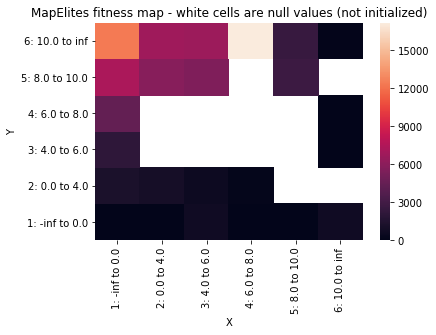

In [3]:
# read configuration file
config.read('config.ini')

logging.info("Start map elites")
map_E = MapElitesContinuousOpt.from_config(MapElitesContinuousOpt, config)
map_E.run()
